# Kaggle: modelling house prices through linear regression and regularisation
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Since this is my first Kaggle submission, I wanted to keep it fairly straightforward, and follow some of the excellent solutions already out there.  In particular, the logic behind this largely follows the following three workbooks: 


Since this is my first kaggle submission, I wanted to keep things fairly straightforward, and follow the approach of some of the excellent solutions already out there.  In particular, this notebook is largely based on the following three notebooks, but I've tried to build on these by adding some other elements, such as a collinearity matrix, and a standard multiple linear regression for comparison.  
- [Apapiu](https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models)
- [Neviadomski](https://www.kaggle.com/neviadomski/house-prices-advanced-regression-techniques/how-to-get-to-top-25-with-simple-model-sklearn)
- [Juliencs](https://www.kaggle.com/juliencs/house-prices-advanced-regression-techniques/a-study-on-regression-applied-to-the-ames-dataset). 

Also, there is some very nice exploratory data analysis and plots in this notebook: [xchmiao](https://www.kaggle.com/xchmiao/detailed-data-exploration-in-python).

Comments welcome!

## Import packages

In [21]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Stats
from scipy.stats.stats import skew
from scipy.stats.stats import pearsonr

## Import data

In [22]:
# Test and training set
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Combine into one dataset for the purposes of cleaning, and make sure that index continues
data_full = pd.concat([train, test], keys = ['train', 'test'])#ignore_index = True)

In [23]:
# What does the dataset look like?
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## Data cleansing

### Dealing with nulls

In [24]:
# Count the uniques for each column for a given dataframe
def df_uniques(df):
    print('Col name,', 'Number of nulls,', 'Number of unique values', '% of nulls')
    list_of_features = []
    for col in df:
        l = [col, df[col].shape[0] - df[col].count(), df[col].unique().shape[0], '%.3f' %((df[col].shape[0] - df[col].count()) / df[col].shape[0])]
        list_of_features.append(l)
    # Sort by the number of NULLs: 
    list_of_features = sorted(list_of_features, key = lambda x: x[1], reverse = True)
    return list_of_features

df_uniques(train)

Col name, Number of nulls, Number of unique values % of nulls


[['PoolQC', 1453, 4, '0.995'],
 ['MiscFeature', 1406, 5, '0.963'],
 ['Alley', 1369, 3, '0.938'],
 ['Fence', 1179, 5, '0.808'],
 ['FireplaceQu', 690, 6, '0.473'],
 ['LotFrontage', 259, 111, '0.177'],
 ['GarageType', 81, 7, '0.055'],
 ['GarageYrBlt', 81, 98, '0.055'],
 ['GarageFinish', 81, 4, '0.055'],
 ['GarageQual', 81, 6, '0.055'],
 ['GarageCond', 81, 6, '0.055'],
 ['BsmtExposure', 38, 5, '0.026'],
 ['BsmtFinType2', 38, 7, '0.026'],
 ['BsmtQual', 37, 5, '0.025'],
 ['BsmtCond', 37, 5, '0.025'],
 ['BsmtFinType1', 37, 7, '0.025'],
 ['MasVnrType', 8, 5, '0.005'],
 ['MasVnrArea', 8, 328, '0.005'],
 ['Electrical', 1, 6, '0.001'],
 ['Id', 0, 1460, '0.000'],
 ['MSSubClass', 0, 15, '0.000'],
 ['MSZoning', 0, 5, '0.000'],
 ['LotArea', 0, 1073, '0.000'],
 ['Street', 0, 2, '0.000'],
 ['LotShape', 0, 4, '0.000'],
 ['LandContour', 0, 4, '0.000'],
 ['Utilities', 0, 2, '0.000'],
 ['LotConfig', 0, 5, '0.000'],
 ['LandSlope', 0, 3, '0.000'],
 ['Neighborhood', 0, 25, '0.000'],
 ['Condition1', 0, 9, '0.0

In [25]:
# The following features have a crazy number of nulls 
# PoolQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage 

# From looking at the data dictionary, these NAs are not necessarily a problem - but "NA" or nUll is misleading, so let's replace them
# Alley: NA = no alley -> replace with "None"
# MiscFeature: other features (e.g. tennis court) - NA = no other feature -> replace with "None"
# Fence: NA = no fence -> replace with "None"
# FireplaceQu: you guessed it -> replace with "None"

In [26]:
# Let's get a neat list of the null columns - need to combine both datasets for this
null_columns = [col for col in data_full.columns if data_full[col].isnull().any()]
print(null_columns)

['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF', 'Utilities']


In [27]:
# Define a function to replace nulls for many columns: 
def fill_nulls(df, col_list, na_val):
    for col in col_list:
        df[col].fillna(value = na_val, inplace = True)
    return df

In [28]:
# Categorical fields with an obvious meaning NA -> 'None'
nulls_to_none = ['PoolQC', 'Fence', 'MiscFeature', 'Alley', 'FireplaceQu', 'MasVnrType', 'BsmtCond', 
                 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 
                 'GarageQual', 'GarageCond', 'KitchenQual']
# Numerical fields with an obvious meaning NA -> 0
nulls_to_zero = ['LotFrontage', 'MasVnrArea', 'BsmtQual', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 
                 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF']

# Categorical fields with a less obvious interpretation - guessing that NA means 'None' (there are very few anyway)
nulls_to_zero_2 = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd']
nulls_to_other = ['SaleType', 'Functional']

# Apply to both test and training sets:
for df in [train, test]: 
    fill_nulls(df, nulls_to_none, 'None')
    fill_nulls(df, nulls_to_zero, 0)
    fill_nulls(df, nulls_to_zero_2, 0)
    fill_nulls(df, nulls_to_other, 'Other')
# NB we still have 'data_full' which has not been updated yet

### Data types
Let's make sure everything is in the correct data type.  Pandas will have a go at importing things correctly, but this is good practice to make sure that things haven't gone awry. Ultimately we'll want to use dummy variables for categorical data anyway.

In [30]:
# Print out data types
def data_types(df):
    for col in df:
        print(col, type(df[col][1]))   

In [31]:
data_types(train)

Id <class 'numpy.int64'>
MSSubClass <class 'numpy.int64'>
MSZoning <class 'str'>
LotFrontage <class 'numpy.float64'>
LotArea <class 'numpy.int64'>
Street <class 'str'>
Alley <class 'str'>
LotShape <class 'str'>
LandContour <class 'str'>
Utilities <class 'str'>
LotConfig <class 'str'>
LandSlope <class 'str'>
Neighborhood <class 'str'>
Condition1 <class 'str'>
Condition2 <class 'str'>
BldgType <class 'str'>
HouseStyle <class 'str'>
OverallQual <class 'numpy.int64'>
OverallCond <class 'numpy.int64'>
YearBuilt <class 'numpy.int64'>
YearRemodAdd <class 'numpy.int64'>
RoofStyle <class 'str'>
RoofMatl <class 'str'>
Exterior1st <class 'str'>
Exterior2nd <class 'str'>
MasVnrType <class 'str'>
MasVnrArea <class 'numpy.float64'>
ExterQual <class 'str'>
ExterCond <class 'str'>
Foundation <class 'str'>
BsmtQual <class 'str'>
BsmtCond <class 'str'>
BsmtExposure <class 'str'>
BsmtFinType1 <class 'str'>
BsmtFinSF1 <class 'numpy.int64'>
BsmtFinType2 <class 'str'>
BsmtFinSF2 <class 'numpy.int64'>
BsmtUn

In [32]:
# By pasting the above list into a spreadsheet and cross checking with the data dictionary, we can 
# see which category each field should be

# statsmodel requires all fieldsnames to begin with letters, so let's sort this out now.
train = train.rename(columns = {'1stFlrSF': 'FirstFlrSF','2ndFlrSF': 'SecondFlrSF','3SsnPorch': 'ThreeSsnPorch'})
test = test.rename(columns = {'1stFlrSF': 'FirstFlrSF','2ndFlrSF': 'SecondFlrSF','3SsnPorch': 'ThreeSsnPorch'})
data_full = pd.concat([train, test], keys = ['train', 'test'])

# Makes lists of each type
categories = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
              'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 
              'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
              'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'Heating', 
              'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 
              'GarageFinish', 'GarageCars', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 
              'SaleCondition']
floats = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
          'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
          'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

ints = ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
         'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces']

bools = ['CentralAir']

feature_names = categories + floats + ints + bools

# Define a function for converting a list of columns to a particular type: 
def convert_col_type(df, cols, type):
    for col in cols:
        df[col] = df[col].astype(type)

In [33]:
# Convert each column for both test and training sets:
for df in [train, test]:
    convert_col_type(df, categories, 'category')
    convert_col_type(df, floats, 'float')
    convert_col_type(df, ints, 'int')
    convert_col_type(df, bools, 'bool')
    
# Re-define the full dataset
data_full = pd.concat([train, test], keys = ['train', 'test'])

In [34]:
# Check new data types  
data_types(train)

Id <class 'numpy.int64'>
MSSubClass <class 'numpy.int64'>
MSZoning <class 'str'>
LotFrontage <class 'numpy.float64'>
LotArea <class 'numpy.float64'>
Street <class 'str'>
Alley <class 'str'>
LotShape <class 'str'>
LandContour <class 'str'>
Utilities <class 'str'>
LotConfig <class 'str'>
LandSlope <class 'str'>
Neighborhood <class 'str'>
Condition1 <class 'str'>
Condition2 <class 'str'>
BldgType <class 'str'>
HouseStyle <class 'str'>
OverallQual <class 'numpy.int64'>
OverallCond <class 'numpy.int64'>
YearBuilt <class 'numpy.int64'>
YearRemodAdd <class 'numpy.int64'>
RoofStyle <class 'str'>
RoofMatl <class 'str'>
Exterior1st <class 'str'>
Exterior2nd <class 'str'>
MasVnrType <class 'str'>
MasVnrArea <class 'numpy.float64'>
ExterQual <class 'str'>
ExterCond <class 'str'>
Foundation <class 'str'>
BsmtQual <class 'str'>
BsmtCond <class 'str'>
BsmtExposure <class 'str'>
BsmtFinType1 <class 'str'>
BsmtFinSF1 <class 'numpy.float64'>
BsmtFinType2 <class 'str'>
BsmtFinSF2 <class 'numpy.float64'>


## Collinearity
First, let's check to see which predictors are correlated; there are many features that essentially encode the same information in different way 

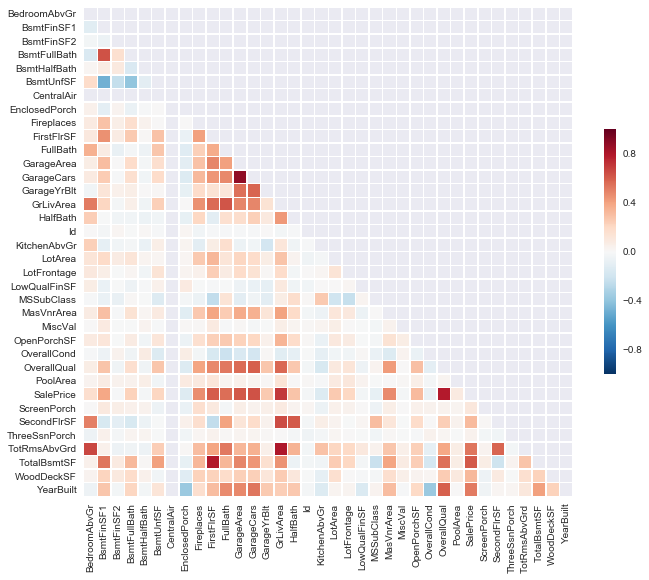

In [35]:
# Compute the correlation matrix
corr = data_full.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, #cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# Simpler version (but too small to be useful)
#plt.matshow(data_full.corr())

In [36]:
# Which predictors are mostly closely correlated with SalePrice?
corr['SalePrice'].sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
FirstFlrSF       0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
SecondFlrSF      0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
GarageYrBlt      0.261366
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
LotFrontage      0.209624
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
ThreeSsnPorch    0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
CentralAir            NaN
Name: SalePrice, dtype: float64

The most highly correlated predictors relate to size: OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, FirstFlrSF. This intuitively makes sense.

## Motivating plots

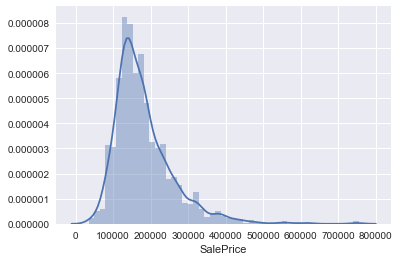

In [37]:
# What's the distribution of prices?
sales_price = train['SalePrice']
graph = sns.distplot(sales_price)

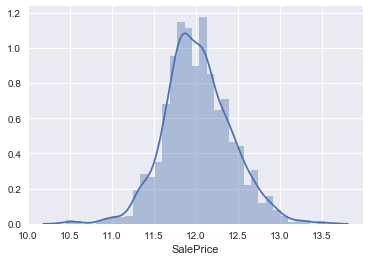

In [38]:
# Let's log-tranform this: 
sales_prices_log = np.log1p(sales_price)
graph = sns.distplot(sales_prices_log)

In [39]:
# This looks much better, so let's replace the SalePrice with the log-transformed version (will need to exponentiate predictions)
train['SalePrice'] = np.log1p(train['SalePrice'])
# Re-define the full dataset - and work on this until we are ready to split out test and train sets again
data_full = pd.concat([train, test], keys = ['train', 'test'])

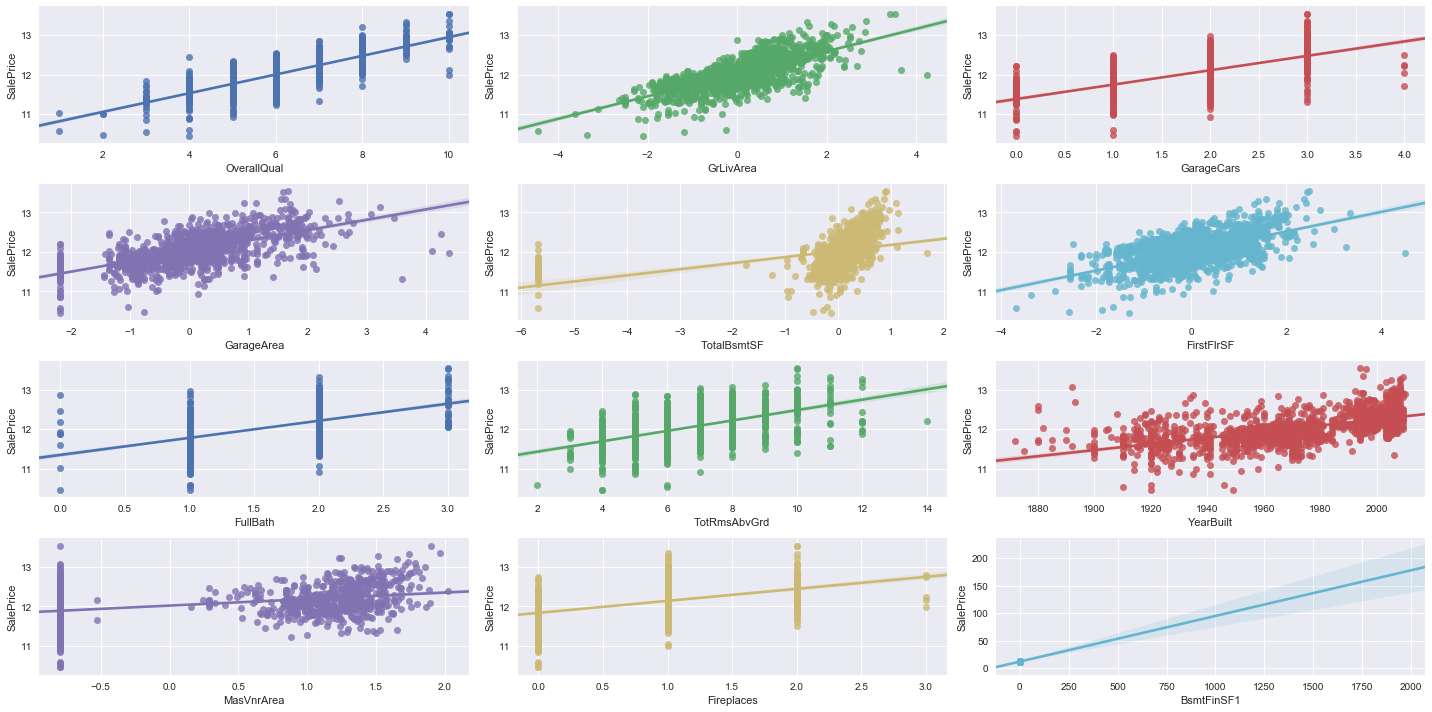

In [83]:
# Let's look at the plots of the important features identified above with SalePrice
fig, axs = plt.subplots(ncols=3, nrows=4, figsize = (20,10))
sns.regplot(x='OverallQual', y='SalePrice', data=data_full, ax=axs[0,0])
sns.regplot(x='GrLivArea', y='SalePrice', data=data_full, ax=axs[0,1])
sns.regplot(x='GarageCars',y='SalePrice', data=data_full, ax=axs[0,2])
sns.regplot(x='GarageArea',y='SalePrice', data=data_full, ax=axs[1,0])
sns.regplot(x='TotalBsmtSF',y='SalePrice', data=data_full, ax=axs[1,1])
sns.regplot(x='FirstFlrSF',y='SalePrice', data=data_full, ax=axs[1,2])
sns.regplot(x='FullBath',y='SalePrice', data=data_full, ax=axs[2,0])
sns.regplot(x='TotRmsAbvGrd',y='SalePrice', data=data_full, ax=axs[2,1])
sns.regplot(x='YearBuilt',y='SalePrice', data=data_full, ax=axs[2,2])
sns.regplot(x='MasVnrArea',y='SalePrice', data=data_full, ax=axs[3,0])
sns.regplot(x='Fireplaces',y='SalePrice', data=data_full, ax=axs[3,1])
sns.regplot(x='BsmtFinSF1',y='SalePrice', data=data_full, ax=axs[3,2])
fig.tight_layout()

Many of these are also skewed to the left, so let's log-transform any variables with a skewness greater than 1

In [45]:
skewed_features = data_full[floats].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 1]
skewed_features.sort_values(ascending = False)

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
ThreeSsnPorch    11.376065
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
FirstFlrSF        1.469604
BsmtFinSF1        1.425230
GrLivArea         1.269358
TotalBsmtSF       1.156894
dtype: float64

In [46]:
skewed_features = skewed_features.index

In [47]:
# Now let's log-transform the skewed features
for col in skewed_features:
   data_full[col] = np.log1p(data_full[col])

## Standardising numeric features

In [48]:
# Standardise numeric features (normalise)
numeric_features = data_full.loc[:,floats]
numeric_features_st = (numeric_features - numeric_features.mean())/numeric_features.std()

In [49]:
data_full.loc[:,floats] = numeric_features_st

### Split test-train sets again

In [50]:
# split out the test and train sets again
train = data_full.ix['train']
test = data_full.ix['test']

## Linear regression

In [51]:
# For the purposes of a multiple regression, let's use statsmodel rather than scikit learn, as it gives us
# more information, such as p-values, and hence, which regressors are important.
import statsmodels.formula.api as smf

# create a fitted model with the features that are floats: 
#lm = smf.ols(formula='SalePrice ~ LotFrontage + LotArea + MasVnrArea + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + FirstFlrSF + SecondFlrSF + LowQualFinSF + GrLivArea + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + ThreeSsnPorch + ScreenPorch + PoolArea + MiscVal + OverallQual + OverallCond + BsmtFullBath + BsmtHalfBath + FullBath + BedroomAbvGr + KitchenAbvGr + TotRmsAbvGrd + Fireplaces', data=train).fit()
formula = 'SalePrice ~ ' + ' + '.join(feature_names)
lm = smf.ols(formula=formula, data=train).fit()

# print the coefficients
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     69.55
Date:                Wed, 03 May 2017   Prob (F-statistic):               0.00
Time:                        14:38:06   Log-Likelihood:                 1444.1
No. Observations:                1460   AIC:                            -2268.
Df Residuals:                    1150   BIC:                            -629.4
Df Model:                         309                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.7885      1.822     -0.433      0.665      -4.363       2.786
MSZoning[T.FV]               0.4604      0.055      8.390      0.000       0.353       0.568
MSZoning[T.RH]               0.4293      0.054      7.896      0.000       0.323       0.536
MSZoning[T.RL]               0.4295      0.047      9.185      0.000       0.338       0.521
MSZoning[T.RM]               0.4068      0.044      9.281      0.000       0.321       0.493
Street[T.Pave]               0.0664      0.057      1.161      0.246      -0.046       0.179
Alley[T.None]               -0.0035      0.019     -0.184      0.854      -0.041       0.034
Alley[T.Pave]                0.0246      0.027      0.894      0.372      -0.029       0.078
LotShape[T.IR2]              0.0245      0.019      1.283      0.200      -0.013       0.062
LotShape[T.IR3]              0.0410      0.040      1.036      0.300      -0.037       0.118
LotShape[T.Reg]              0.0122      0.008      1.610      0.108      -0.003       0.027
LandContour[T.HLS]           0.0398      0.024      1.684      0.092      -0.007       0.086
LandContour[T.Low]          -0.0154      0.029     -0.530      0.596      -0.073       0.042
LandContour[T.Lvl]           0.0243      0.017      1.427      0.154      -0.009       0.058
Utilities[T.NoSeWa]         -0.1520      0.122     -1.242      0.215      -0.392       0.088
LotConfig[T.CulDSac]         0.0202      0.015      1.352      0.177      -0.009       0.050
LotConfig[T.FR2]            -0.0444      0.018     -2.408      0.016      -0.081      -0.008
LotConfig[T.FR3]            -0.1101      0.057     -1.924      0.055      -0.222       0.002
LotConfig[T.Inside]         -0.0119      0.008     -1.488      0.137      -0.028       0.004
LandSlope[T.Mod]             0.0272      0.018      1.483      0.138      -0.009       0.063
LandSlope[T.Sev]            -0.0941      0.045     -2.081      0.038      -0.183      -0.005
Neighborhood[T.Blueste]      0.0052      0.094      0.056      0.956      -0.179       0.189
Neighborhood[T.BrDale]      -0.0045      0.054     -0.084      0.933      -0.110       0.101
Neighborhood[T.BrkSide]     -0.0162      0.045     -0.362      0.718      -0.104       0.072
Neighborhood[T.ClearCr]     -0.0403      0.044     -0.911      0.363      -0.127       0.047
Neighborhood[T.CollgCr]     -0.0546      0.035     -1.552      0.121      -0.124       0.014
Neighborhood[T.Crawfor]      0.0637      0.041      1.557      0.120      -0.017       0.144
Neighborhood[T.Edwards]     -0.1345      0.038     -3.517      0.000      -0.210      -0.059
Neighborhood[T.Gilbert]     -0.0588      0.037     -1.570      0.117      -0.132       0.015
Neighborhood[T.IDOTRR]      -0.0816      0.051     -1.612      0.107      -0.181       0.018
Neighborhood[T

In [52]:
# Best features
lm.pvalues.sort_values(ascending = False, inplace=False).tail(10)

RoofMatl[T.CompShg]    1.056676e-10
GrLivArea              3.081269e-11
RoofMatl[T.WdShngl]    1.924101e-12
LotArea                8.292263e-15
MSZoning[T.RH]         6.703679e-15
MSZoning[T.FV]         1.408158e-16
OverallQual            3.937123e-17
MSZoning[T.RL]         1.857571e-19
MSZoning[T.RM]         8.086248e-20
OverallCond            2.215795e-24
dtype: float64

In [53]:
# Worst features
lm.pvalues.sort_values(ascending = False, inplace=False).head(10)

YearRemodAdd[T.1957]       0.999582
HouseStyle[T.2.5Unf]       0.988001
Functional[T.Min2]         0.978128
ExterQual[T.TA]            0.969479
YearRemodAdd[T.1981]       0.969240
FireplaceQu[T.TA]          0.966327
Functional[T.Min1]         0.960038
Condition1[T.RRNe]         0.956397
Neighborhood[T.Blueste]    0.955686
ExterQual[T.Gd]            0.953012
dtype: float64

It looks like the most important predictors relate to the type of roofing material (perhaps correlated with certain neighbourhoods, or architecture styles, that are in turn correlated with demographic factors), and features related to the size of the house (LotArea, GrLivArea, OverallQual), and the zone of the area (MSZoning).  This intuitively makes sense.  

On the other hand, features that are fairly useless relate to remodelling of the house, and exterior surface features.

Since there are so many features, it would make sense to either remove these by one of the following: 
- backward elimination
- principal component analysis
- regularisation to penalise the extra features.  This avoids over-fitting.  In particular, lasso regularisation performs some feature selection for us.

In this notebook, I'll take the latter approach.

## Splitting the testing and training sets again; define dummy variables for categories

In [54]:
# Features - remove the thing we're trying to predict!
features = data_full.drop('SalePrice', axis = 1)

# Create dummy variables - for each categorical data, make several boolean flags
features = pd.get_dummies(features)

# Make matrices to pass to scikit learn:
X_train = features[:train.shape[0]]
X_test = features[train.shape[0]:]
y = train['SalePrice']

# Verify that the number of features has been increased due to the dummy variables:
print('Number of features in original dataset, including categorical fields: ', train.shape[1], 
      '\nNumber of features, including dummy variables for categorical fields: ', X_train.shape[1])

Number of features in original dataset, including categorical fields:  81 
Number of features, including dummy variables for categorical fields:  385


## Ridge regularisation (L2 regularisation)

In [55]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
#from sklearn.metrics import mean_squared_error

In [56]:
# Define root-mean-square-error function - use 10-fold cross-validation
# You have to use neg_mean_squared_error because mean_squared_error will be deprecated in future
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse

# Invoke Ridge regularisation
model_ridge = Ridge()

In [57]:
# Tune parameters - the only parameter is alpha - the larger alpha, the larger the penalty for extra predictors
alphas = [0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# Work out the RMSE for each value of the alphas above: 
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)

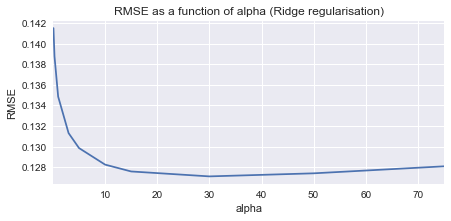

In [58]:
# Let's plot the RMSE as a function of alpha
matplotlib.rcParams['figure.figsize'] = (7,3)
cv_ridge.plot(title = 'RMSE as a function of alpha (Ridge regularisation)')
plt.xlabel('alpha')
plt.ylabel('RMSE')

We want to chose the value of $\alpha$ that minimises the chart above. The extreme cases are $\alpha = 0$, which corresponds to no penalty for each extra predictor, and $\alpha\to\inf$ which corresponds to a null model.  We want a balance between flexibility and over-fitting, which represents the minimium of this chart.

In [59]:
cv_ridge.min()

0.12710231088917179

In [60]:
# This looks like it correpsonds to alpha = 30, so let's fit the model with that.
model_ridge = Ridge(alpha = 30)
model_ridge.fit(X_train, y)

Ridge(alpha=30, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

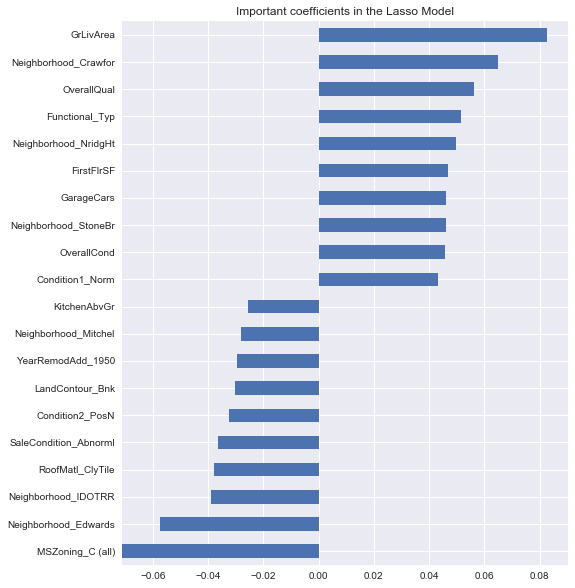

In [61]:
# What are the important coefficients here?
coef_ridge = pd.Series(model_ridge.coef_, index = X_train.columns)
important_coef_ridge = pd.concat([coef_ridge.sort_values().head(10), coef_ridge.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
important_coef_ridge.plot(kind = "barh")
plt.title('Important coefficients in the Lasso Model')

In [62]:
# How many features were eliminated? 
print("Ridge picked " + str(sum(coef_ridge != 0)) + " features and eliminated the other " + str(sum(coef_ridge == 0)) + " features")

Ridge picked 377 features and eliminated the other 8 features


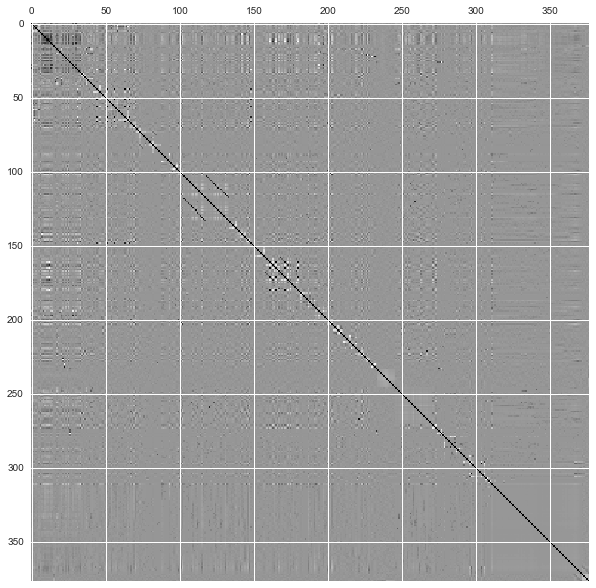

In [63]:
# Let's see what the correlation matrix looks like now: 
c = coef_ridge[coef_ridge != 0]
corr = features[c.index].corr()
plt.matshow(corr)

This is much bigger (more features due to dummy variables) but it looks like lasso has eliminated a lot of the correlated variables that we saw above in the correlation matrix. 

In [64]:
#let's look at the residuals as well:
def plot_residuals(model, X_train, y):
    matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
    preds = pd.DataFrame({"preds":model.predict(X_train), "true":y})
    preds["residuals"] = preds["true"] - preds["preds"]
    preds.plot(x = "preds", y = "residuals",kind = "scatter")

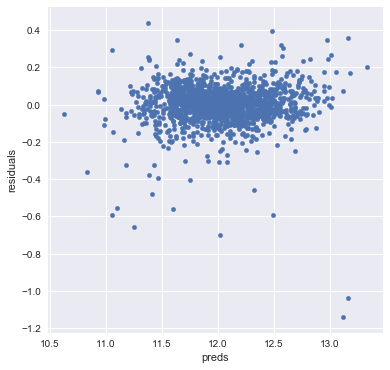

In [65]:
plot_residuals(model_ridge, X_train, y)

These look pretty good - nicely clustered around 0.

## Lasso regularisation (L1 regularisation)
The advantage of Lasso regularisation is that it performs some feature selection.  We'll use Lasso cross-validation to choose the $\alpha$ for us.

In [66]:
model_lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
                     max_iter = 50000, cv = 10).fit(X_train, y)
# Coefficients of each predictor:
coef_lasso = pd.Series(model_lasso.coef_, index = X_train.columns)

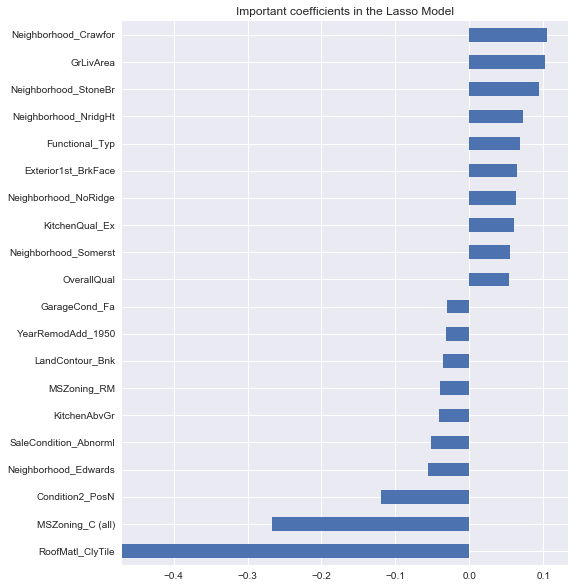

In [67]:
# What are the important coefficients here?
important_coef_lasso = pd.concat([coef_lasso.sort_values().head(10), coef_lasso.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
important_coef_lasso.plot(kind = "barh")
plt.title('Important coefficients in the Lasso Model')

A lot of these are on the list of features picked out by the normal multiple regression without regularisation. Not the hugely negative coefficient for Clay Tile - there is only one house with this feature, so this is not actually a particuarly important feature.

In [68]:
data_full['RoofMatl'].value_counts()

CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Roll          1
ClyTile       1
Metal         1
Membran       1
Name: RoofMatl, dtype: int64

In [69]:
data_full[data_full['RoofMatl'] == 'ClyTile']['SalePrice']

train  1298    11.982935
Name: SalePrice, dtype: float64

In [70]:
# How many features were eliminated? 
print("Lasso picked " + str(sum(coef_lasso != 0)) + " features and eliminated the other " + str(sum(coef_lasso == 0)) + " features")

Lasso picked 103 features and eliminated the other 282 features


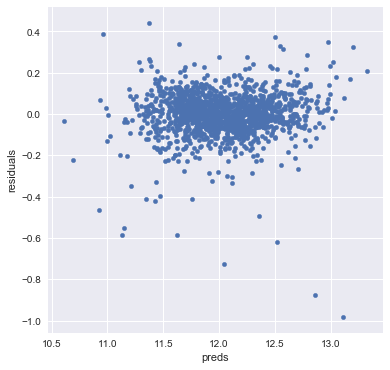

In [71]:
# Let's have a look at the residuals of this too.    
plot_residuals(model_lasso, X_train, y)

## Elastic net regularisation


In [72]:
from sklearn.linear_model import ElasticNetCV

In [73]:
model_elastic = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
model_elastic.fit(X_train, y)
alpha = model_elastic.alpha_
ratio = model_elastic.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.7
Best alpha : 0.0006


In [74]:
coef_elastic = pd.Series(model_elastic.coef_, index = X_train.columns)

In [75]:
# How many features were eliminated? 
print("Elastic picked " + str(sum(coef_elastic != 0)) + " features and eliminated the other " + str(sum(coef_elastic == 0)) + " features")

Elastic picked 131 features and eliminated the other 254 features


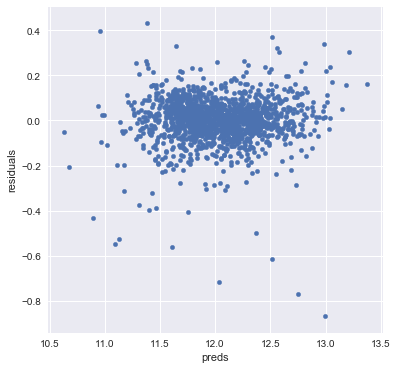

In [76]:
plot_residuals(model_elastic, X_train, y)

These look almost identical to the residuals for the Lasso, and the number of features is larger, so it's probably more prone to over-fitting.  I'm sticking with the Lasso regularisation.

# Make predictions

In [77]:
ridge_preds = np.expm1(model_ridge.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))
elastic_preds = np.expm1(model_elastic.predict(X_test))

In [78]:
preds = {'ridge': ridge_preds, 'lasso': lasso_preds, 'elastic': elastic_preds}

In [79]:
from datetime import datetime

In [80]:
def make_export_table(model):
    kaggle_export = pd.DataFrame({
        'id': test['Id'],
        'SalePrice': preds[model]
    },
    columns = ['id', 'SalePrice'])
    return kaggle_export

In [81]:
for model in ['ridge', 'lasso', 'elastic']:
    filebasename = 'kaggle_export'
    timestamp = datetime.today().strftime('%Y%m%d-%H%M%S')
    filename = filebasename + timestamp + model
    table = make_export_table(model)
    table.to_csv(filename, index = False)

These submissions give the following scores on the public leaderboard. This puts me in the top 31% of submissions as of 3 May 2017.
- Elastic - 0.12414
- Lasso - 0.12377
- Ridge - 0.12431
As others have noted in their notebooks, these scores show that you can do reasonably well with pretty straightforward models. 

Comments welcome!